In [74]:
import pandas as pd
import openpyxl
import gensim
import gensim.corpora as corpora
import nltk
import spacy
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.ensemble import  RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [50]:
df = pd.read_excel("20250602_Anfragen_Sample.xlsx")
df_clean = clean_text(df, "Kundenanfrage")
df_clean["Kundenanfrage"] = df_clean["Kundenanfrage"].apply(remove_stopwords_from_series)
df_clean["tokens"] = df_clean["Kundenanfrage"].str.split()
id2word = corpora.Dictionary(df_clean["tokens"])
texts = df_clean["tokens"]
corpus = [id2word.doc2bow(text) for text in texts]

In [45]:
nltk.download('stopwords')
stopwords_l = stopwords.words("german")

def tokenize(text):
    nltk.download('stopwords')
    stopwords_l = stopwords.words("german")
    tokens = gensim.utils.simple_preprocess(text, deacc=True)
    tokens = [token for token in tokens if token not in stopwords_l]
    return tokens



def clean_text(df: pd.DataFrame, x : str):

    df[x] = df[x].replace(r"^(.*?),","",regex= True)
    df[x] = df[x].replace(r"(Viele|Mit|Herzliche|Liebe|Beste|Freundliche).*Grüß.*", "", regex=True)
    df[x] = df[x].replace(r"Vielen Dank.*","",regex = True)
    df[x] = df[x].replace(r'[^\s\w]+','',regex = True)
    df[x] = df[x].str.lower()

    return df


def remove_stopwords_from_series(text):
    words = text.split()
    words_filtered = [w for w in words if w not in stopwords_l]
    return " ".join(words_filtered)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\milas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [78]:
df_group = pd.DataFrame(df_clean.groupby("Unterkategorie2")["Kundenanfrage"].agg(lambda x: " ".join(x)))

Adressänderung


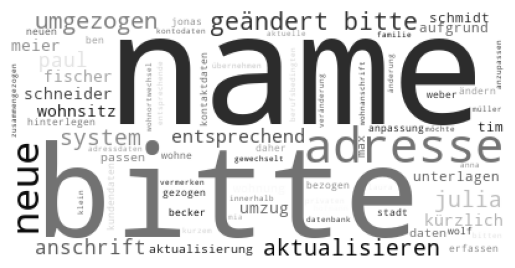

Auslandsbuchung


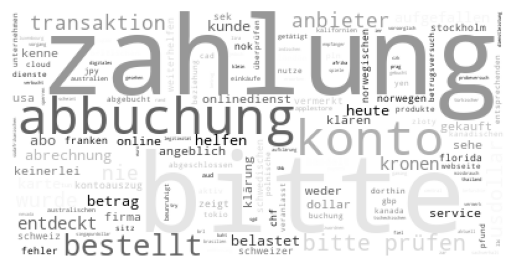

Bearbeitungsdauer


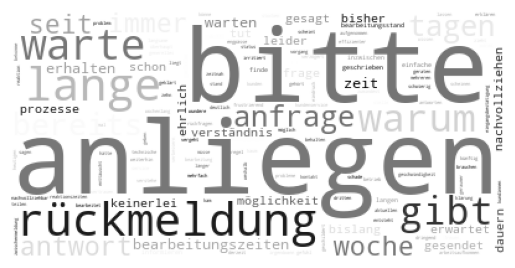

Gebühren


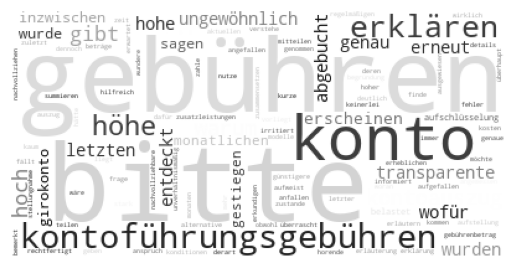

Gerätewechsel


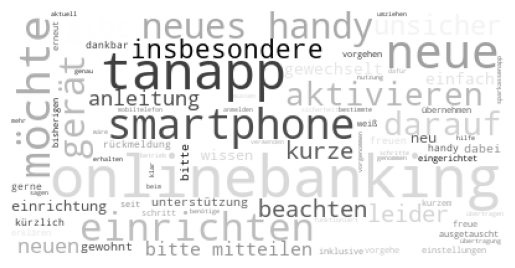

Girokonto


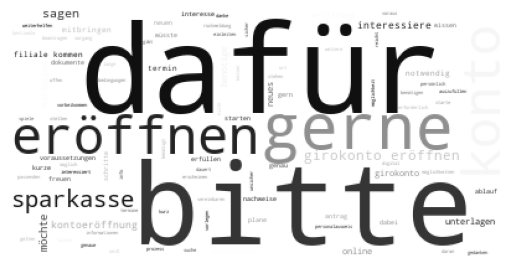

Kreditkarte


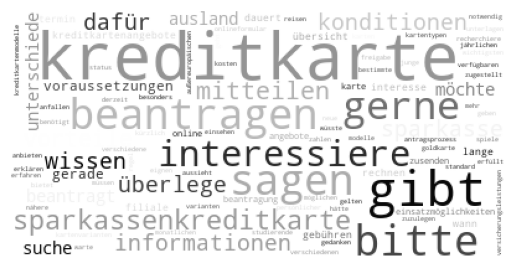

Nachhaltige Geldanlagen


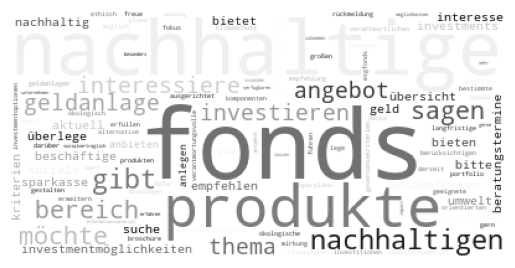

Namensänderung


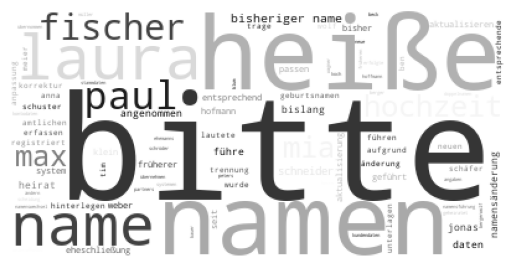

Phishing


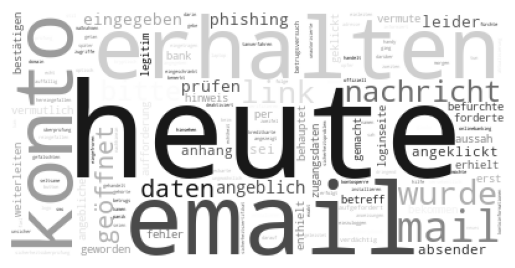

Servicequalität


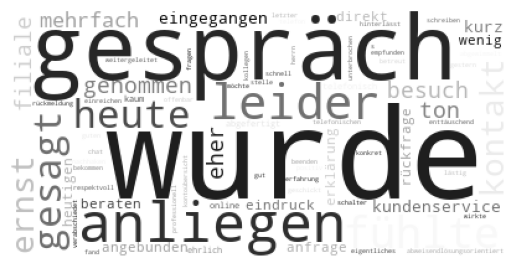

TAN-Verfahren


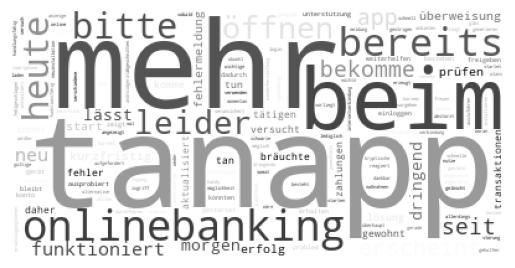

In [85]:
wordcloud_dic = {}
for index,row in df_group.iterrows():
    wc = WordCloud(background_color='white', colormap = 'binary').generate(row["Kundenanfrage"])
    wordcloud_dic[index] = wc
for k,v in wordcloud_dic.items():
    print(k)
    plt.axis("off")
    plt.imshow(v)
    plt.show()

In [ ]:
df_clean["encoded_categories"] = LabelEncoder().fit_transform(df_clean["Unterkategorie2"])
n_topics = [3,6,9,12]
alphas = [0.75,1]
betas = [0.1,0.5]
parameters_RF = {'max_depth':[25],
                 'max_samples':[0.6],
                 'max_features':[9]}
df_score = pd.DataFrame({'alpha':[],'beta':[],'n_topics' :[],'max_depth' : [], 'max_features':[], 'max_samples':[],'accuracy':[]})

for a in alphas:
    for b in betas:
        for n in n_topics:
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=n, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha = a,
                                                eta = b,
                                                per_word_topics=False)
            topics = lda_model.print_topics(num_words=10)
            t = lda_model.get_document_topics(corpus,minimum_probability=0)
            columns = []
            for i in range(0,n):
                df[f"topic_{i}"] = [t[d][i][1] for d in range(0,len(t))]
                columns.append(f"topic_{i}")
            X = df[columns]
            y = df['encoded_categories']
            X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)

            #Random Forest
            RF = RandomForestClassifier()

            #Hyperparameter Tuning ausführen
            CV_RF = GridSearchCV(RF,
                                parameters_RF,
                                scoring = 'accuracy',
                                cv = 10)

            #Mit dem Trainingsatz trainieren
            CV_RF.fit(X_train,y_train)
            print(CV_RF.best_score_)
            #Feature importances anzeigen
            print(CV_RF.best_estimator_.feature_importances_)
            y_pred_RF = CV_RF.predict(X_test)
            #Accuracy-Wert für den Testsatz speichern
            RF_score = accuracy_score(y_test,y_pred_RF)
            df_score2 = pd.DataFrame({'alpha':[a],'beta':[b], 'n_topics' : [n],
                                    'max_depth' : [CV_RF.best_estimator_.get_params()["max_depth"]], 
                                    'max_features':[CV_RF.best_estimator_.get_params()["max_features"]], 
                                    'max_samples':[CV_RF.best_estimator_.get_params()["max_samples"]],
                                    'accuracy':[RF_score]})
            df_score = pd.concat([df_score,df_score2],axis = 0)


0.5176470588235293
[0.34714801 0.30294302 0.34990898]
0.5908088235294118
[0.2293963  0.16422137 0.12667595 0.11250391 0.24943999 0.11776248]
0.5477941176470589
[0.18612001 0.0939689  0.07994888 0.05228067 0.17731014 0.08796274
 0.08353797 0.15006434 0.08880636]
0.6430147058823529
[0.15369396 0.05660042 0.06187553 0.04146643 0.16497865 0.06761403
 0.06791881 0.06609364 0.04030774 0.05978055 0.14561309 0.07405714]
0.4764705882352941
[0.41705255 0.27339836 0.30954909]
0.5830882352941177
[0.2454405  0.09772467 0.13536765 0.19451058 0.23079053 0.09616608]
0.6643382352941176
[0.1774715  0.09203994 0.06944203 0.06497768 0.20054776 0.06873506
 0.09175365 0.17033333 0.06469904]
0.6507352941176471
[0.18604512 0.09726159 0.06074009 0.04571352 0.07761313 0.09387121
 0.06320744 0.13970772 0.02999662 0.03080594 0.13163338 0.04340422]
0.4261029411764706
[0.36342766 0.32160978 0.31496256]
0.5783088235294118
[0.24938384 0.13320641 0.14163354 0.14474458 0.21479146 0.11624017]
0.6378676470588236
[0.18960